# Video Recommendations

import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns
import itertools

sns.set_style("ticks")
fontpath = expanduser('/Users/horta/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

In [1]:
import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns
import itertools

sns.set_style("ticks")
fontpath = expanduser('/Users/horta/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

In [4]:
# Read channels
from helpers import bins_y_s, bins_t_s, colors, mean_confidence_interval
from sqlitedict import SqliteDict
import matplotlib.colors as cl
import pandas as pd
import networkx as nx
import numpy as np
import glob

SRC = "/Users/horta/Dropbox/data/youtube_radicalization/"
cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "Control"]
cats_all = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "left",
            "center", "left-center", "right-center", "right"]
cats_to_control = ["left", "center", "left-center", "right-center", "right"]
df_sources = pd.read_csv(SRC + "/sources_final_trimmed.csv")
df_sources.Category = df_sources.Category.apply(lambda x: x if x not in cats_to_control else "Control")
df_sources = df_sources.set_index("Id")

In [5]:
channels = {}
G = nx.DiGraph()
G.add_node("Other", category="Other", subscriberCount=0)

helper_dict = {}
helper_nodes = {}

for channel_id, tmp in df_sources.iterrows():
    tmp = dict(tmp)
    if tmp["Category"] not in cats:
        continue
        
    # Reads metadata from youtube data
    df_tmp = pd.read_csv(SRC + "/yt/{}.csv".format(channel_id))
    helper_nodes[channel_id] = []
    for v in df_tmp["video_id"].values:
        helper_dict[v] = channel_id

for channel_id, tmp in df_sources.iterrows():
    if tmp["Category"] not in cats:
        continue
    
    G.add_node(channel_id, name=tmp["Name"], category=tmp["Category"])

count = 0
for v in glob.glob(SRC + "/vd/*/*.csv"):
    channel_id = v.split("/")[-1][:-4]
    
    if channel_id not in helper_nodes:
        continue
        
    try:
        df_tmp = pd.read_csv(v)
    except:
        continue

    for _, tmp in df_tmp.iterrows():
        tmp = dict(tmp)
        for vd_id, _, _ in eval(tmp["recommendations"])[:10]:

            if vd_id in helper_dict:# and helper_dict[vd_id] != channel_id:
                count += 1
                helper_nodes[channel_id].append(helper_dict[vd_id])
            elif vd_id not in helper_dict:
                count += 1
                helper_nodes[channel_id].append("Other")

#     print(v)
#     print(count)

from collections import Counter
for cid in helper_nodes.keys():
    clen = len(helper_nodes[cid])
    edges_dict = {k:i/clen for k, i in Counter(helper_nodes[cid]).items()}
    for ocid, pct in edges_dict.items():
        G.add_edge(cid, ocid, pct=pct)
        
nx.write_graphml(G, SRC+ "/video_graph.graphml")

In [6]:
G = nx.read_graphml(SRC + "/video_graph.graphml")
G_channel = nx.read_graphml(SRC+ "/channels_graph.graphml")

In [8]:
lambdas = [
    lambda x:  df_sources.loc[x, "Category"] == "Alt-lite",
    lambda x:  df_sources.loc[x, "Category"] == "Intellectual Dark Web",
    lambda x:  df_sources.loc[x, "Category"] == "Alt-right",
    lambda x:  df_sources.loc[x, "Category"] == "Control"
]

titles = [
    "Alt-lite",
    "I.D.W.",
    "Alt-right",
    "Control"
]

df_list = []
df_helper_pos = pd.read_csv(SRC +"/helpers/helper_channels.csv")
c = {}

for l, t in zip(lambdas, titles):


    node_list = [k for k, n in  G.nodes.data() if n["category"] != "Other" and l(k)]
    print(t)
    subs = np.array([G_channel.nodes[n]["subscriberCount"] for n in node_list])
    subs = subs/np.sum(subs)
    print(sum(subs))
    cats_nodes = np.array([G.nodes[n]["category"] for n in node_list])
    
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Alt-right"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Alt-lite"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Intellectual Dark Web"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Control"]))
    print(len(node_list))
    print(len(subs))

    num_its = 10000
    num_steps = 6
    c = {**{(cat,t):np.zeros((num_its, num_steps)) for cat in cats}, **c}

    for it in range(num_its):
        candidates = node_list
        weight = subs
        c_ = False
        for k in range(num_steps):
            n = np.random.choice(candidates, p = weight)
            if n == "Other":
                break
            cat = df_sources.loc[n, "Category"]
            df_list.append({"channel_id": n, 
                            "category":cat,
                            "step": k,
                            "Starting": t})
            c[(cat,t)][it, k:] = 1
            tmp = [(j, G[i][j]["pct"]) for i,j in list(G.out_edges(n)) if j != "Other"]
            if len(tmp) == 0:
                k+=1
                break
            candidates, weight = list(zip(*tmp))
            weight = [w/sum(weight) for w in weight]
        while k < num_steps:
            df_list.append({"channel_id": n, 
                            "category":"Other",
                            "step": k,
                            "Starting": t})  
            k += 1
            
            
df = pd.DataFrame(df_list)
df["isar"] = (df.category == "Alt-right").astype(float)
df["isidw"] = (df.category == "Intellectual Dark Web").astype(float)
df["isal"] = (df.category == "Alt-lite").astype(float)
df["isctrl"] = (df.category == "Control").astype(float)

Alt-lite
1.0
Alt-lite 0
Alt-lite 1.0
Alt-lite 0
Alt-lite 0
114
114
I.D.W.
0.9999999999999998
I.D.W. 0
I.D.W. 0
I.D.W. 0.9999999999999998
I.D.W. 0
89
89
Alt-right
1.0
Alt-right 1.0
Alt-right 0
Alt-right 0
Alt-right 0
88
88
Control
1.0
Control 0
Control 0
Control 0
Control 1.0
68
68


In [9]:
import itertools
helper_edges_count = {}
df_list = []
for c1, c2 in itertools.product(cats + ["Other"], repeat=2):
    total_src = sum([G[u][v]["pct"] for u, v in G.edges if G.nodes[u]["category"] == c1])
    val = sum([G[u][v]["pct"] for u, v in G.edges if G.nodes[u]["category"] == c1 and 
                                                     G.nodes[v]["category"]  == c2])
    try:
        helper_edges_count[(c1,c2)] = str(round(val/total_src*100,2))+ "\%"
        val
    except:
        helper_edges_count[(c1,c2)] = 0
    
    c1 = c1.replace("Intellectual Dark Web", "I.D.W.")
    c2 = c2.replace("Intellectual Dark Web", "I.D.W.")
    df_list.append({"Source":c1, "Destination":c2, "val": round(val/total_src*100,2) if total_src != 0 else 0})
    
df_edges = pd.DataFrame(df_list)
df_edges = df_edges.pivot(index='Source', columns='Destination', values='val')

In [11]:
print(df_edges.to_latex())

\begin{tabular}{lrrrrr}
\toprule
Destination &  Alt-lite &  Alt-right &  Control &  I.D.W. &  Other \\
Source    &           &            &          &         &        \\
\midrule
Alt-lite  &     12.70 &       0.13 &     3.24 &    2.46 &  81.47 \\
Alt-right &      1.15 &       8.55 &     3.38 &    1.89 &  85.03 \\
Control   &      0.08 &       0.00 &    14.84 &    0.31 &  84.77 \\
I.D.W.    &      1.57 &       0.03 &     3.03 &   19.03 &  76.35 \\
Other     &      0.00 &       0.00 &     0.00 &    0.00 &   0.00 \\
\bottomrule
\end{tabular}



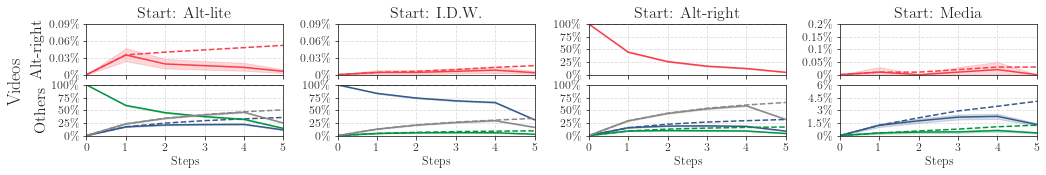

In [12]:
fig = plt.figure(constrained_layout=False, figsize=(16.5,2))
gs = fig.add_gridspec(nrows=2, ncols=4, wspace=0.275, hspace=0.2, top=0.9, left=0.1)

axes = [
    fig.add_subplot(gs[0, 0]), 
    fig.add_subplot(gs[0, 1]), 
    fig.add_subplot(gs[0, 2]), 
    fig.add_subplot(gs[0, 3])
]

for idx, (ax, tt) in enumerate(list(zip(axes, titles))):
    df_tmp = df[df["Starting"] == tt]
    ax.plot(list(range(6)), c["Alt-right", tt].mean(axis=0), "--", color=colors["Alt-right"])
    sns.lineplot(x="step", y="isar", data=df_tmp, color=colors["Alt-right"], ax=ax)
    ax.set_ylim([0, 0.006])
    ax.set_xticks(list(range(6)))
    ax.set_xlim([0,5])
    ax.set_yticks([0, 0.003, 0.006, 0.009])
    ax.xaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.yaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.set_title("Start: " + tt.replace("Control", "Media"))
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticklabels(["0\%", "0.03\%", "0.06\%", "0.09\%"])
    ax.set_xticklabels([])
    
    if idx == 0:
      ax.set_ylabel("Alt-right", fontsize=16, labelpad=5)

axes[-1].set_ylim([0, 0.002])
axes[-1].set_yticks([0, 0.0005, 0.001, 0.0015, 0.002])
axes[-1].set_yticklabels(["0\%", "0.05\%", "0.1\%", "0.15\%", "0.2\%"])

axes[-2].set_ylim([0, 1])
axes[-2].set_yticks([0, 0.25, 0.5, 0.75, 1])
axes[-2].set_yticklabels(["0\%", "25\%", "50\%", "75\%", "100\%"])

axes = [
    fig.add_subplot(gs[1, 0]), 
    fig.add_subplot(gs[1, 1]), 
    fig.add_subplot(gs[1, 2]), 
    fig.add_subplot(gs[1, 3])
]

for idx, (ax, tt) in enumerate(list(zip(axes, titles))):
    df_tmp = df[df["Starting"] == tt]
    ax.plot(list(range(6)), c["Intellectual Dark Web", tt].mean(axis=0), "--", 
            color=colors["Intellectual Dark Web"])
    sns.lineplot(x="step", y="isidw", data=df_tmp, color=colors["Intellectual Dark Web"], ax=ax)
    
    ax.plot(list(range(6)), c["Alt-lite", tt].mean(axis=0), "--", 
            color=colors["Alt-lite"])
    sns.lineplot(x="step", y="isal", data=df_tmp, color=colors["Alt-lite"], ax=ax)
    
    ax.plot(list(range(6)), c["Control", tt].mean(axis=0), "--", 
            color=colors["Control"])
    sns.lineplot(x="step", y="isctrl", data=df_tmp, color=colors["Control"], ax=ax)
    ax.set_ylim([0, 1])
    ax.set_xticks(list(range(6)))
    ax.set_xlim([0,5])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.xaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.yaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xlabel("Steps")
    ax.set_yticklabels(["0\%", "25\%", "50\%", "75\%", "100\%"])

axes[0].set_ylabel("Others", fontsize=16)
axes[-1].set_ylim([0, 0.06])
axes[-1].set_yticks([0, 0.015, 0.03, 0.045, 0.06])
axes[-1].set_yticklabels(["0\%", "1.5\%", "3\%", "4.5\%", "6\%"])
fig.text(0.04, 0.5, 'Videos', va='center', ha='center', rotation='vertical', fontsize=18)

fig.savefig("../imgs/video_graphs.pdf", bbox_inches='tight')
fig.savefig("../imgs/video_graphs.png", bbox_inches='tight')